## Getting Started with the Singular Value Decomposition in Data Analysis

In a recent post we looked at some of the ways that the Singular Value Decomposition (SVD) is used in data science and scientific computing. Often when people are first exposed the Singular Value Decomposition, they learn some of the mathematical properties of it. They may learn that the matrices `U` and `Vt` are orthogonal/unitary and that `S` is a diagonal matrix with singular values sorted from highest to lowest. They may also learn about the relationships between the SVD of $X$ and the eigen decompositions of $X^TX$ and $XX^T$. While these are other properies are vital to an understanding of the SVD, with only this information it may be unclear to many why these features are important in the context of real applications with real data and how they contribute to the many possible applications of the SVD, including the following:

- [Denoising signals](https://en.wikipedia.org/wiki/Noise_reduction)
- [Data compression](https://en.wikipedia.org/wiki/Data_compression)
- [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA)
- [Regression analysis](https://en.wikipedia.org/wiki/Regression_analysis)
- Fluid simulation (i.e., through [Proper Orthogonal Decomposition](https://en.wikipedia.org/wiki/Proper_orthogonal_decomposition))
- [Recommendation systems](https://en.wikipedia.org/wiki/Recommender_system)


In my last post we saw that the SVD isolates dominant signals in our data and that by combining a small number of signals we can denoise and compress our data as well as project our data into a low-dimensional space for analysis, computation reduction, and prediction. In this post, we'll get into more of the details behind how this important matrix decomposition works and how you can use it in Python. We will also show some of the Python code used to generate the examples in my previous post. By examining the technical details, our aim is to gain intuition into how this decomposition works so that our uses of it are led by critical evaluation rather than as a rote tool.

For the purposes of this post, I'd like to highlight three aspects of the SVD:

- The SVD is a rank decomposition
- Singular values are sorted from highest to lowest
- $U$ captures structure across rows; $V^T$ captures structure across columns


#### The SVD is a rank decomposition

Much of the time when we are referring to the dimensionality of are data we mean the shapes of the arrays that we have. For instance, the below data matrix has a shape of (10,10):

In [1]:
# we'll start with some imports
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import timeit
from PIL import Image, ImageOps

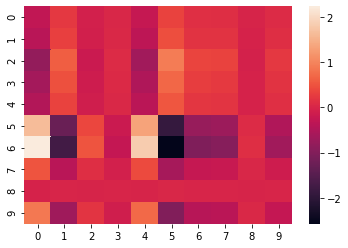

In [2]:
np.random.seed(121)
r1 = np.random.normal(0.0, 0.9, size=(10))
r2 = np.random.normal(0.0, 0.9, size=(10))
data = np.outer(r1, r2)
seaborn.heatmap(data);

On the surface, it may look like there are 10 different columns here with different signals underlying the data. If we look a bit closer, however, we can see that our data consists of the same column over and over. The `r1` vector is just multiplied by different values to generate the matrix:

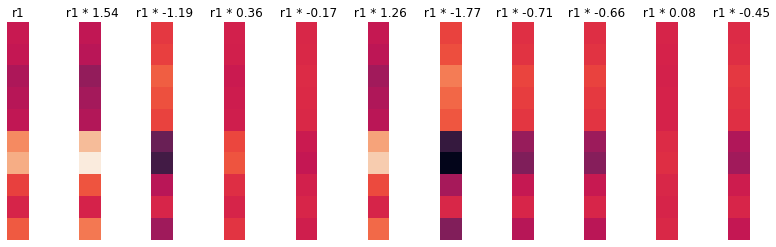

In [3]:
fig, axs = plt.subplots(1, 11, figsize=(14,4))

seaborn.heatmap(ax=axs[0], data=r1[:,None], cbar=False, square=True, vmin=data.min(), vmax=data.max())
axs[0].set_title('r1')
axs[0].axis('off')
for i in range(1,11):
    seaborn.heatmap(ax=axs[i], data=r1[:,None]*r2[i-1], cbar=False, square=True, vmin=data.min(), vmax=data.max())
    axs[i].set_title(f' r1 * {np.round(r2[i-1],2)}')
    axs[i].axis('off')

This data is a rank 1 matrix (i.e. it's the same column over and over). We can gaurantee that a matrix will be rank 1 if the matrix is made by taking the outer product of two vectors, as is the case here. In such a case, the data is very easy to compress. Instead of storing all 10*10=100 elements of our data matrix, we need only store 10+10=20 elements. 

In [4]:
data.nbytes, r1.nbytes + r2.nbytes

(800, 160)

If we add two rank 1 matrices together, we get a rank 2 matrix:

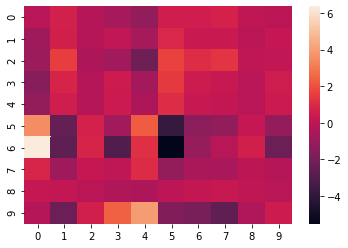

In [5]:
np.random.seed(125)
r3 = np.random.normal(0.0, 0.9, size=(10))
r4 = np.random.normal(0.0, 0.9, size=(10))
new_data = (data * 2) + np.outer(r3, r4)
seaborn.heatmap(new_data);

We can understand this new matrix as a mixture of two rank 1 matrices. Since we multipled the original matrix by 2 before combining the matrices, the signal of our first matrix comes out stronger. In this case, then, our new data is an uneven mixture of underlying signals. The SVD is a general method for unmixing the most important signals in a data matrix.

Let's generate a new random matrix `X` and compute its SVD:

In [6]:
np.random.seed(125)
X = np.random.normal(0.0, 0.9, size=(15,10))
U,S,Vt = np.linalg.svd(X)

Now let's visualize the `X` along with its SVD:

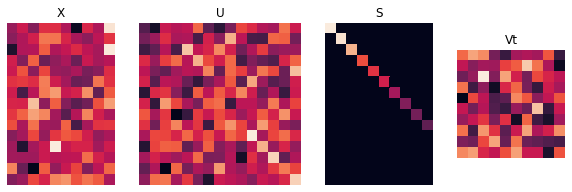

In [7]:
fig, axs = plt.subplots(1,4, figsize=(10,10),gridspec_kw={'width_ratios': [10,15,10,10]}) 
                                          #'height_ratios': [15,15,10,10]})
sparse_s = np.zeros(X.shape)
np.fill_diagonal(sparse_s, S)
seaborn.heatmap(ax=axs[0], data=X, cbar=False, square=True)
seaborn.heatmap(ax=axs[1], data=U, cbar=False, square=True)
seaborn.heatmap(ax=axs[2], data=sparse_s, cbar=False, square=True)
seaborn.heatmap(ax=axs[3], data=Vt, cbar=False, square=True)


axs[0].set_title('X')
axs[1].set_title('U')
axs[2].set_title('S')
axs[3].set_title('Vt')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off');

In [8]:
print('X shape:', X.shape)
print('U shape:', U.shape)
print('S shape:', S.shape)
print('Vt shape:', Vt.shape)

X shape: (15, 10)
U shape: (15, 15)
S shape: (10,)
Vt shape: (10, 10)


If we take the outer product of the first column of `U` and the first row of `Vt` we get a rank 1 matrix. We can do the same for second column of `U` and the second row of `Vt`. The same pattern continues for the rest of the columns and rows of the matrices:

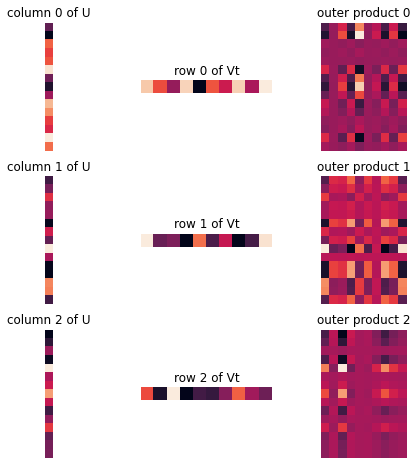

In [9]:
fig, axs = plt.subplots(3,3, figsize=(8,8)) 
                                          #'height_ratios': [15,15,10,10]})

for i in range(3):
    seaborn.heatmap(ax=axs[i,0], data=U[i,:][:,None], cbar=False, square=True)
    seaborn.heatmap(ax=axs[i,1], data=Vt[:,i][None,], cbar=False, square=True)
    seaborn.heatmap(ax=axs[i,2], data=np.outer(U[i,:],Vt[:,i]), cbar=False, square=True)
    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,2].axis('off')
    axs[i,0].set_title(f'column {i} of U')
    axs[i,1].set_title(f'row {i} of Vt')
    axs[i,2].set_title(f'outer product {i}')

We can understand `X` as a mixture of these rank 1 matrices. The singular values in `S` tell us how important each of these rank 1 matrices are.

#### Singular values are sorted from highest to lowest

For our data, some of these rank 1 matrices are more important than others. We use the singular values in $\Sigma$ to tell us how important each rank 1 matrix is. The singular values are sorted from highest to lowest. So the first matrix is more important than the second and so forth. Let's look at an example of this works:



We'll start by create a rank 1 matrix and then adding some noise to it:

In [10]:
# create our data matrix
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

# make a rank 1 matrix
data = 2/np.cosh(x1grid)/np.cosh(x2grid)

# let's add some noise
data_noisey = data + np.random.normal(0.0, 0.2, size=x1grid.shape)

<Figure size 432x288 with 0 Axes>

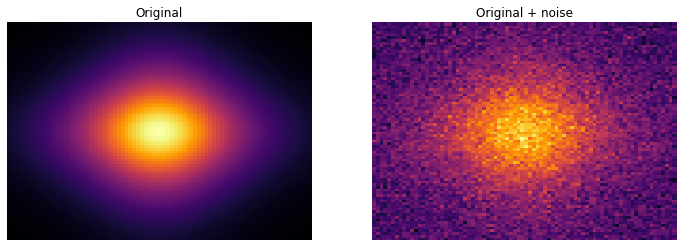

In [11]:
plt.set_cmap('inferno')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].pcolor(x1grid, x2grid, data, shading='auto')
axs[0].axis('off')
axs[0].set_title('Original')
axs[1].pcolor(x1grid, x2grid, data_noisey, shading='auto')
axs[1].axis('off')
axs[1].set_title('Original + noise');

Now that we have our data, let's see if we can denoise this matrix with the SVD. First let's compute the SVD:

In [12]:
U, S, Vt = np.linalg.svd(data_noisey)

Let's take a look at the singular values to see how many rank 1 matrices or 'modes' we should use.


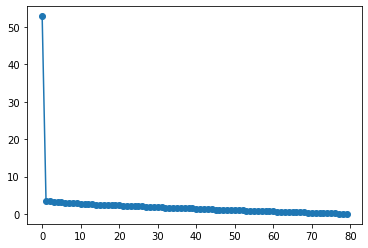

In [13]:
plt.plot(S, 'o-');

It looks like there's just one mode that is far more important than the rest. This is what we should expect since our original noise-free matrix is rank 1. Sure enough, the first mode looks very similar to our original data with the noise removed:

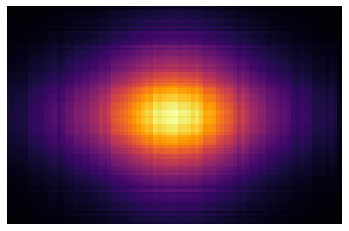

In [14]:
plt.pcolor(x1grid, x2grid,np.outer(U[:,0], Vt[0,:]), shading='auto')
plt.axis('off');

The rest of the modes mostly correspond to the noise. If we multiply each of these rank 1 matrices with their corresponding singular value and add them together, then we can approximate the noisey dataset.

<Figure size 432x288 with 0 Axes>

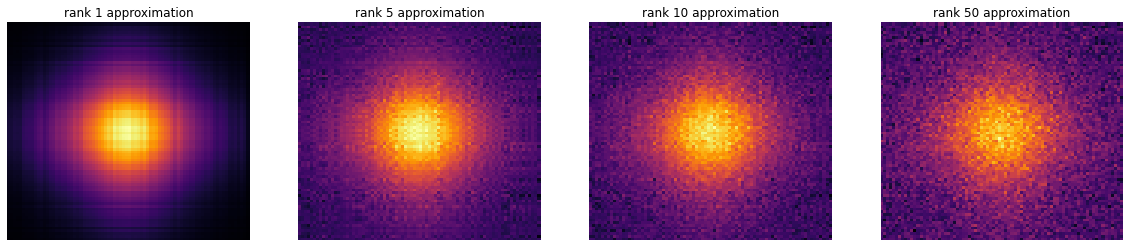

In [15]:
plt.set_cmap('inferno')
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

data_approximations = []
ranks = [1,5,10,50]
for r in ranks:
    data_approximations.append(U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:])

for i,r in enumerate(ranks):
    axs[i].pcolor(x1grid, x2grid, data_approximations[i], shading='auto')
    axs[i].axis('off')
    axs[i].set_title(f'rank {r} approximation')
plt.show();

Returning to an example from my first post, here is an image of Mount Emily in eastern Oregon:

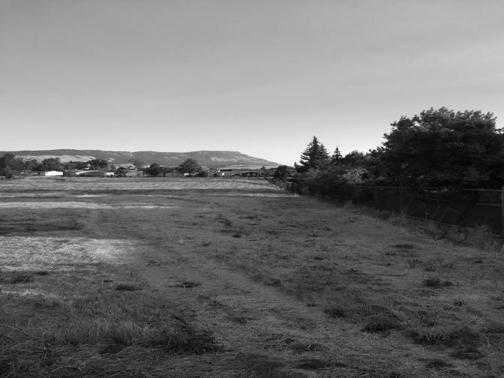

In [16]:
mt_emily = ImageOps.grayscale(Image.open('images/svd1/mt_emily_resized.jpg'))
mt_emily

Let's compute the SVD:

In [17]:
mt_emily = np.array(mt_emily)
U, S, Vt = np.linalg.svd(mt_emily)
mt_emily.shape

(378, 504)

Now let's see how a few low-rank approximations look.

In [18]:
low_rank_approximations = []
n_bytes = []
ranks = [1,5,10,25]
for r in ranks:
    low_rank_approximations.append(U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:])
    n_bytes.append(U[:,:r].nbytes + S[:r].nbytes + Vt[:r,:].nbytes)
    print('shape of U: ',U[:,:r].shape)

shape of U:  (378, 1)
shape of U:  (378, 5)
shape of U:  (378, 10)
shape of U:  (378, 25)


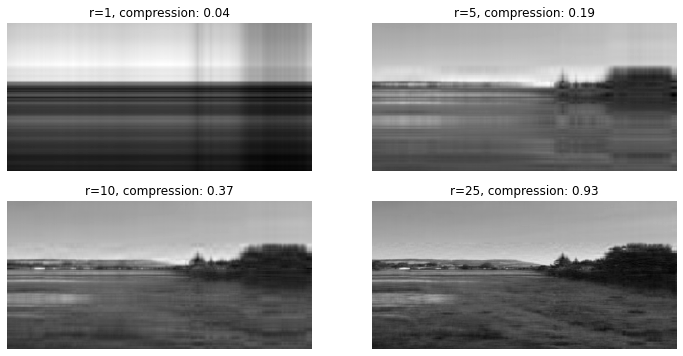

In [19]:
fig, axs = plt.subplots(2,2, figsize=(12,6))

plt.set_cmap('gray')

count = 0
for i in range(2):
    for j in range(2):
        axs[i,j].imshow(low_rank_approximations[count], aspect='auto')
        axs[i,j].axis('off')
        axs[i,j].set_title(f'r={ranks[count]}, compression: {np.round(n_bytes[count]/mt_emily.nbytes, decimals=2)}')
        count += 1

Because With fewer signals, the reconstruction is rather poor but the compression is quite good. As we use more signals, the image reconstructed improves at the cost of worse compression. With only 10 modes, the reconstruction is recognizable as the original image but is quite blurry. With 25 modes most of the structure of the image is present. This is reflected in the singular spectrum of the image:

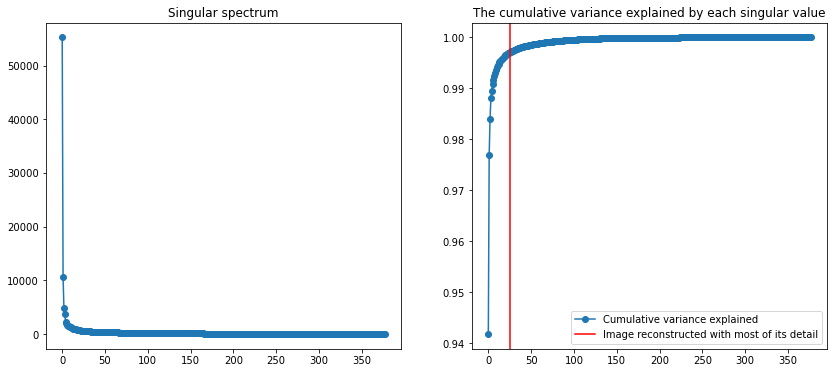

In [20]:
explained_variance = (S ** 2) / (378 - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
ax1.plot(S,'-o')
ax1.set_title('Singular spectrum')
ax2.plot(np.cumsum(explained_variance_ratio), 'o-')
ax2.axvline(x=25, color='r')
ax2.set_title('The cumulative variance explained by each singular value')
ax2.legend(['Cumulative variance explained', 'Image reconstructed with most of its detail']);

The singular values, as a measure of importance, steeply fall until the point at which they nearly flat line. We can see that dominant signals are few in number and that most of the modes offer very little detail. In the right plot, we can see the cumulative variance explained by each singular value. We can explain 99% of the variance with only five or so modes, indicating the this image is very low rank. The red line shows the variance explained after 25 modes. With the possible 378 modes available, only 25 modes are needed to produce a quality reconstruction.

Real-world systems exibit low-rank structure and can be represented well with a restricted number of SVD modes. In many cases, if we have a sense of how many modes we might need, we can use the randomized SVD to calculate only the modes we need. This allows us to bypass some of the computation and memory demands of the full SVD.

#### $U$ captures structure across rows; $V^T$ captures structure across columns

***Still working on this section***

So far we have seen that we can decompose matrices into separate signals in the form of rank 1 matrices that are sorted in order of importance. These rank 1 matrices are created through the combination of columns of `U` and rows of `Vt` via outer product. Just as important as their combination are individual columns and rows of these two matrices in their own right. As we will see, these matrices capture complimentary aspects of our data. 

The columns of `U` are the same shape as the columns of `X` and the rows of `Vt` are the same shape as the rows of `X`.
How we should understand the structure that is captured in `U` and `Vt` depends on hows we organize our data. It is common in time-series analysis to structure our matrices with the columns as individual time points of a set of features (features-by-time points). In this case, the columns of `U` will have the same shapes as our features and will give us the dominant patterns in our feature space. The rows of `Vt` will correspond to the time series of each of the feature patterns in `U`. 



In many data applications, it is common to use the opposite organization (samples-by-features). In this case, the rows of `Vt` hold the dominant feature patterns while the columns of `U` hold the relationships across samples. To illustrate this, let's have a look the [Yale Face Database](http://vision.ucsd.edu/content/yale-face-database/).



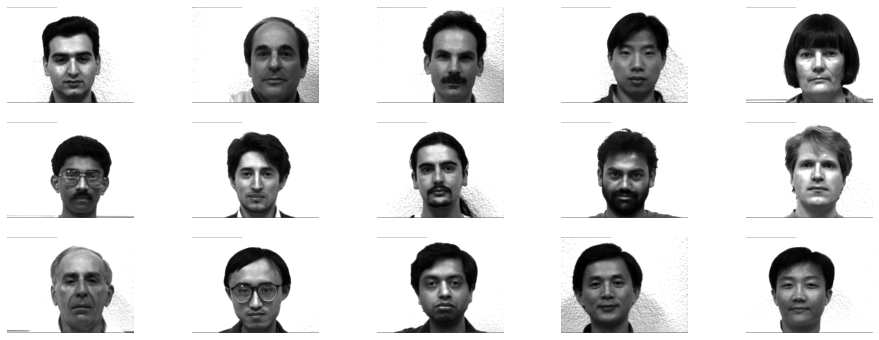

In [21]:
fig, axs = plt.subplots(3,5, figsize=(16,6))

faces = glob.glob('images/yalefaces/*.normal')
count = 0
for i in range(3):
    for j in range(5):
        image = plt.imread(faces[count])
        axs[i,j].imshow(image, cmap='gray')
        axs[i,j].axis('off')
        count += 1

Let's flatten each of these images into a vector and stack them as rows in a matrix (samples-by-features):

In [22]:
data = np.stack([plt.imread(face).flatten() for face in faces], axis=0)
data = data.astype(np.float64)
image_shape = plt.imread(faces[0]).shape
data.shape

(15, 77760)

Now let's compute the SVD:

In [23]:
U,S,Vt = np.linalg.svd(data, full_matrices=False)

Since each row of our matrix is a long array of pixels, the rows of `Vt` can also be thought of as long arrays of pixels. If we take each row of `Vt` and reshape it to our individual image dimensions we get things that look like faces. These are new variable by which we can understand our data. These are sometimes referred to as 'eigenfeatures,' or in this case 'eigenfaces.'

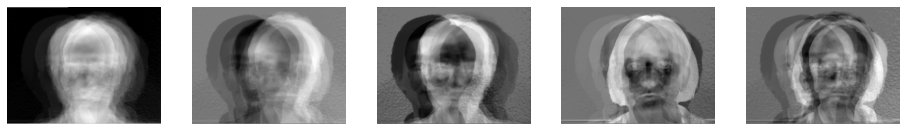

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(16,6))

for i in range(5):
    axs[i].imshow(Vt[i,:].reshape(image_shape), cmap='gray')
    axs[i].axis('off')

Just as the rows of `Vt` correspond to pixels, the columns of `U` correspond to people. We can see how much each person loads onto each of these eigenfaces by looking at the columns of `U`:

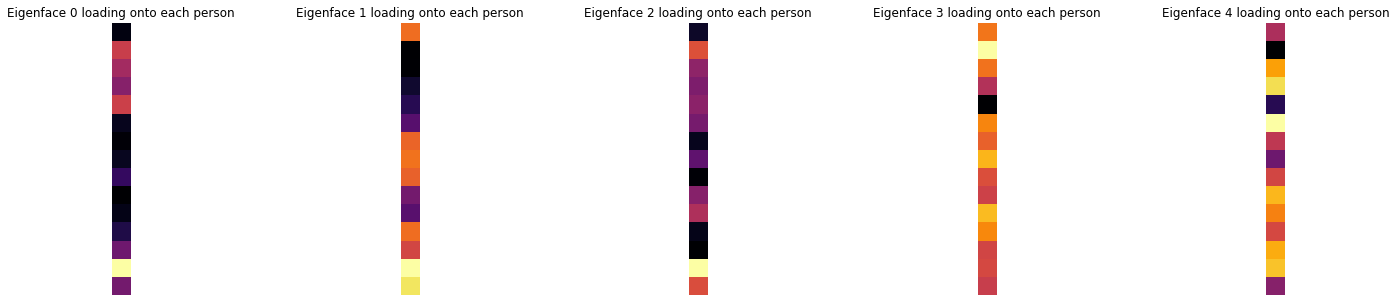

In [25]:
fig, axs = plt.subplots(1,5, figsize=(25,5))

for i in range(5):
    axs[i].imshow(U[:,i][:,None], cmap='inferno')
    axs[i].axis('off')
    axs[i].set_title(f'Eigenface {i} loading onto each person')

For a reconstruction of the entire matrix, the modes are organized in order of importance by the singular values. That does not say anything about the importance of any particular eigenface on any particular face reconstruction. Some eigenfaces are more important for reconstructing certain faces. We can loop through each eigenface and loop through five of the values in of the columns of `U` to reconstruct five individual faces. After each face reconstruction we'll track the error for each of the original faces using the [l2 norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm):

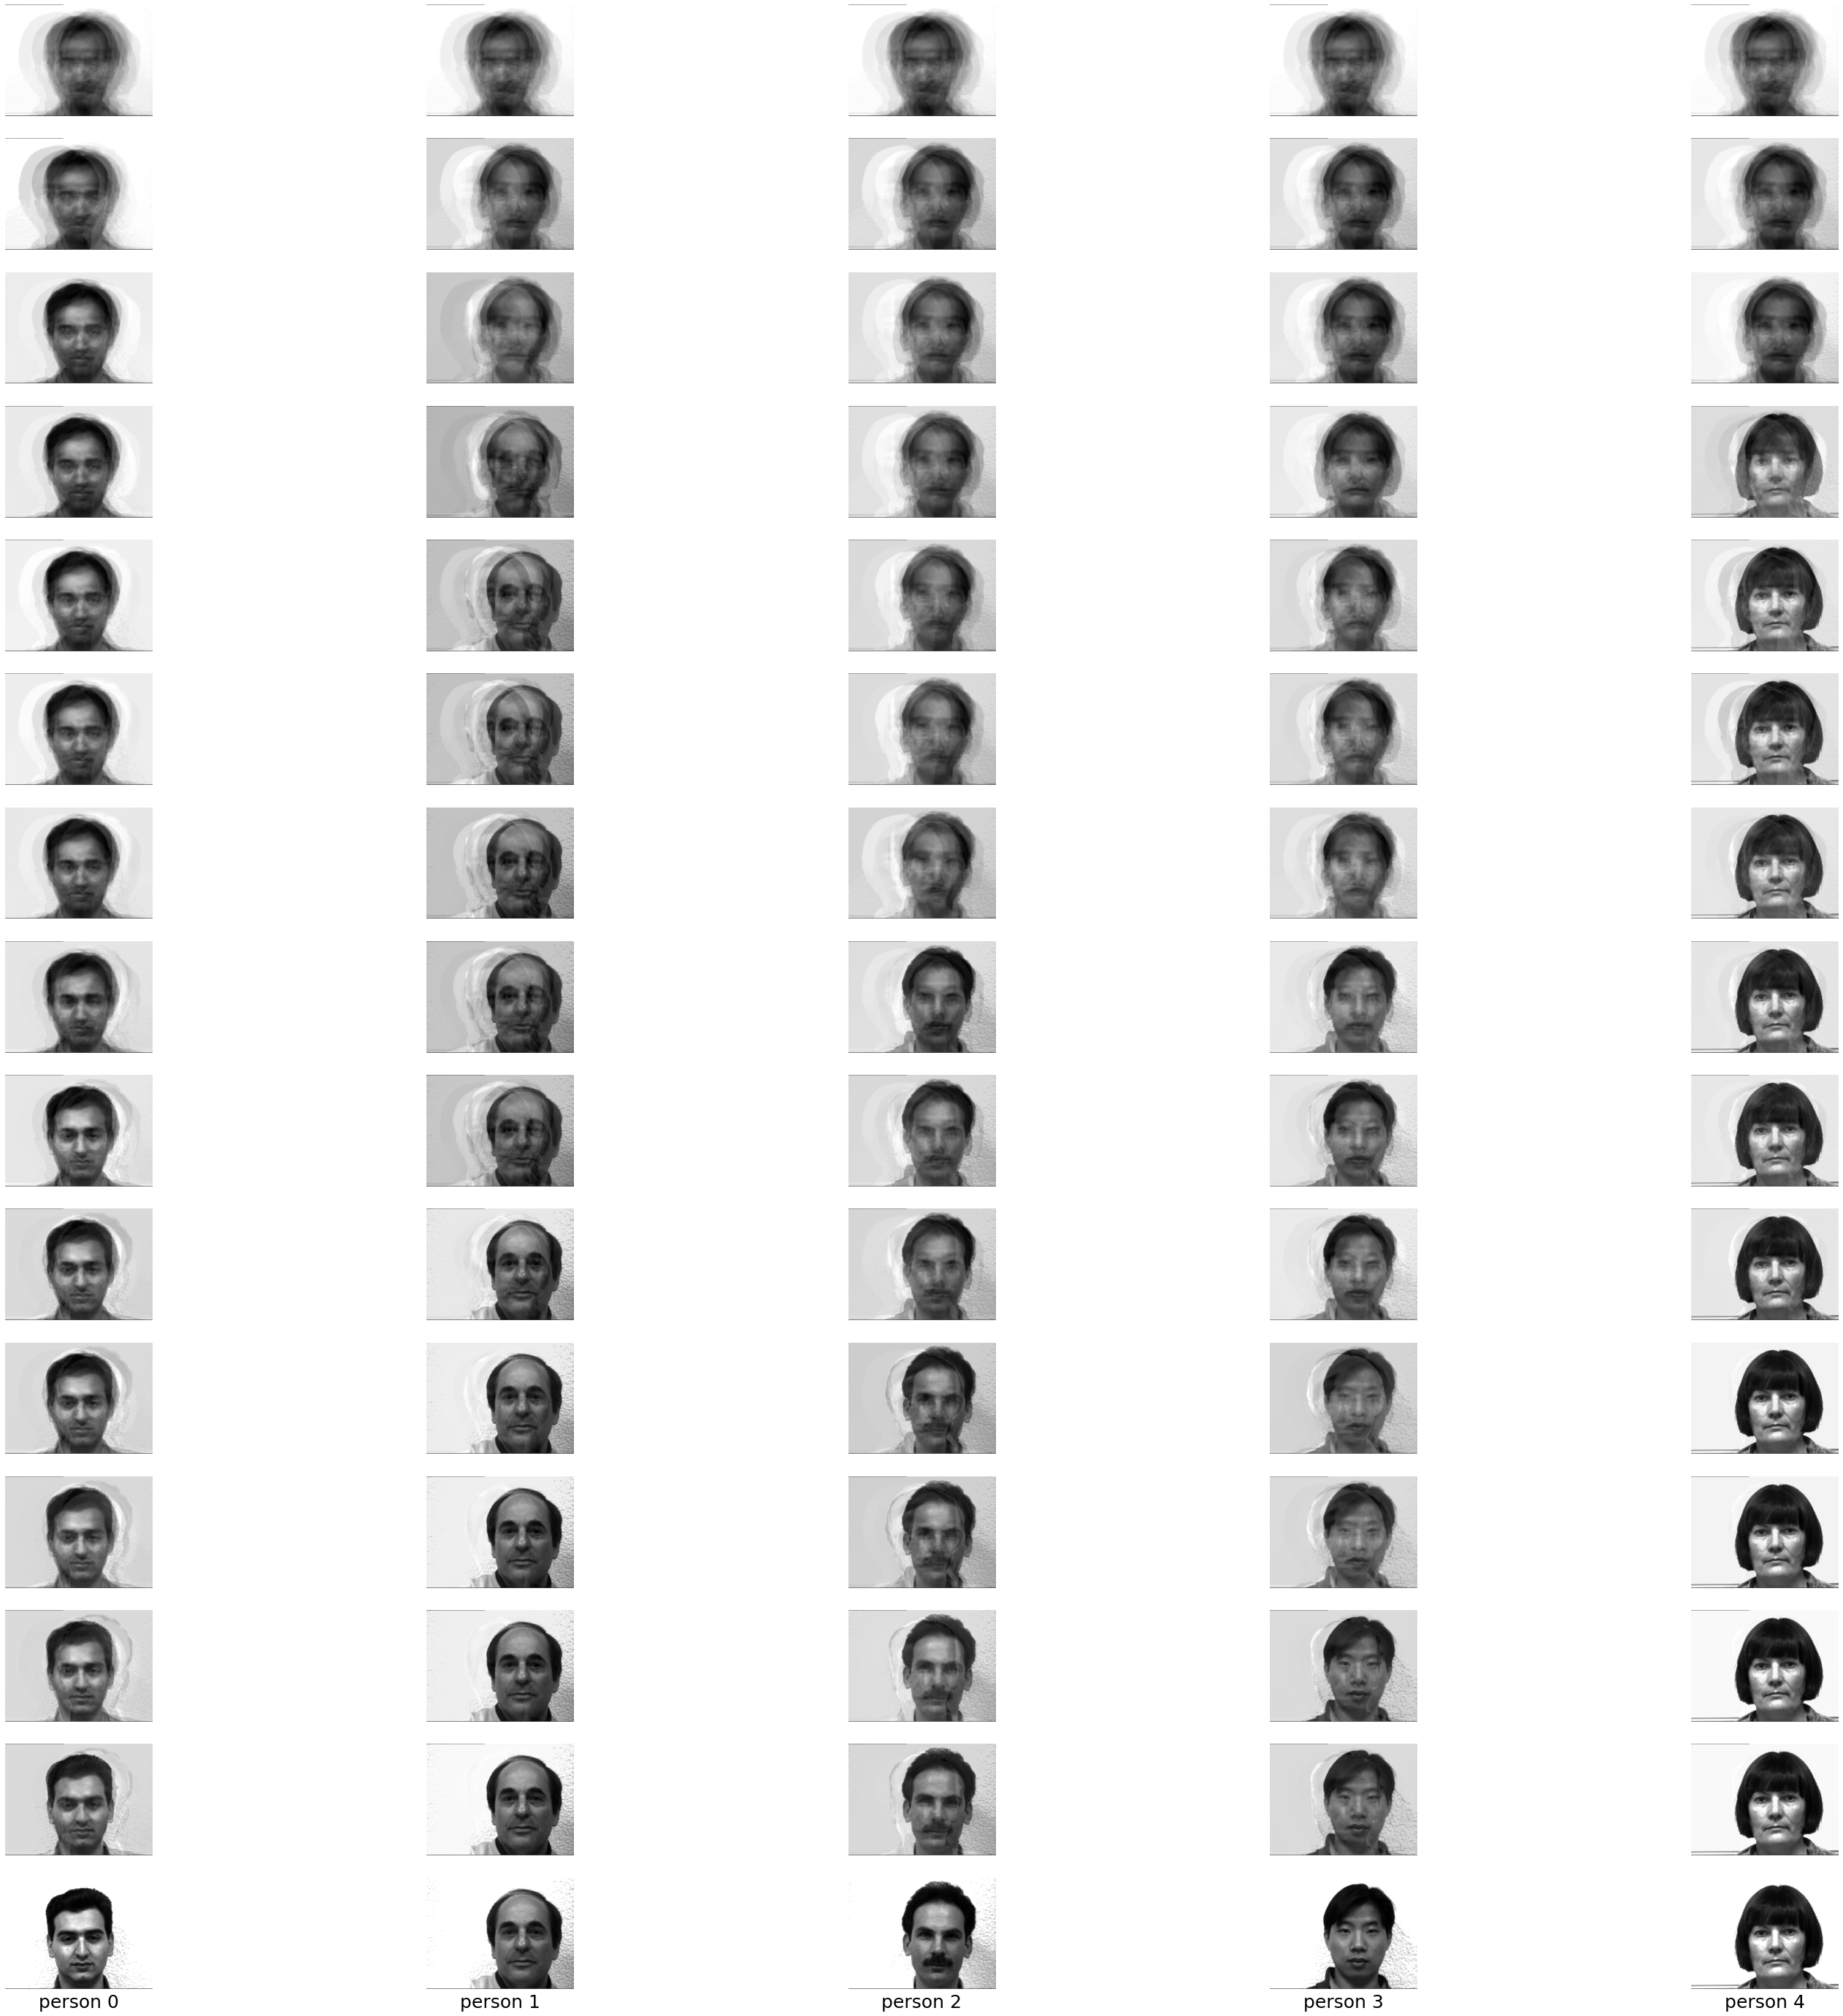

In [26]:
fig, axs = plt.subplots(15, 5, figsize=(50,50))

faces = [np.zeros(Vt.shape[1]) for _ in range(5)]
errors = np.zeros((15,5))

for i in range(15): # each eigenface
    for j in range(5): # each individual person
        faces[j] += U[j,i] * S[i] * Vt[i,:]
        errors[i,j] = np.linalg.norm(data[j,:] - faces[j])
        axs[i,j].imshow(faces[j].reshape(image_shape), cmap='gray')
        axs[i,j].axis('off')
        if i==14:
            axs[i,j].set_title(f'person {j}', y=-0.2, fontsize=25)
        #axs[i,j].set_xlabel(f'person {j}')
        #axs[i,j].set_title(f'{errors[i,j]}')

As we can see, the approximation of each face converges differently. After eigenface 0 each of the images looks the same—they are all eigenface 0 multipled by a different value in the first column of `U` and then scaled by the first singular value. The faces diverge from each other after we add eigenface 1 to the each of the faces. We can plot the errors for each person as we add eigenfaces to their reconstruction:

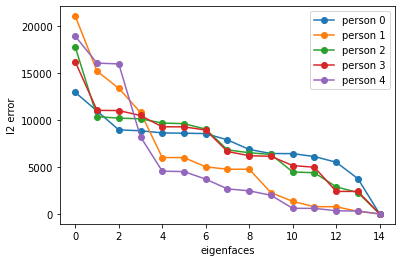

In [27]:
names = [f'person {i}' for i in range(5)]
fig, axis = plt.subplots()
axis.plot(errors[:,0], '-o')
axis.plot(errors[:,1], '-o')
axis.plot(errors[:,2], '-o')
axis.plot(errors[:,3], '-o')
axis.plot(errors[:,4], '-o')
axis.set_ylabel('l2 error')
axis.set_xlabel('eigenfaces')
axis.legend(names);

The convergence path for each of these faces are quite different. Person 1 and Person 4 appear to converge faster at first.

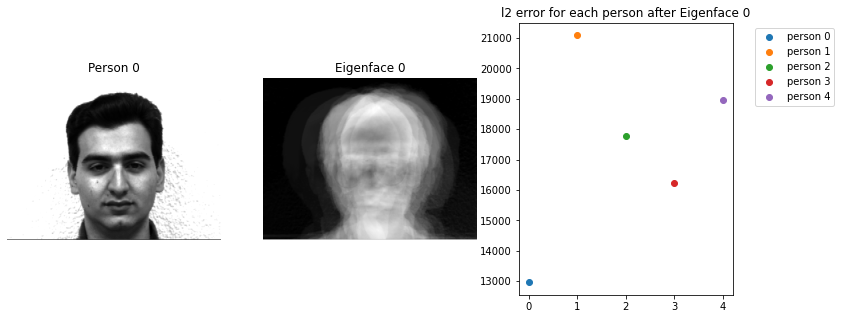

In [28]:
fig, axs = plt.subplots(1,3, figsize=(13,5))

axs[0].imshow(data[0,:].reshape((243, 320)), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Person 0')
axs[1].imshow(Vt[0,:].reshape((243, 320)), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Eigenface 0')
axs[2].scatter([0], errors[0,0])
axs[2].scatter([1], errors[0,1])
axs[2].scatter([2], errors[0,2])
axs[2].scatter([3], errors[0,3])
axs[2].scatter([4], errors[0,4])
axs[2].legend(names, bbox_to_anchor=(1.5, 1))
axs[2].set_title('l2 error for each person after Eigenface 0');


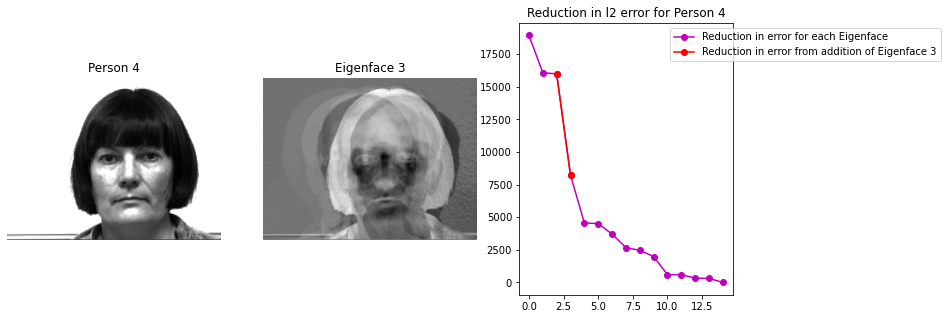

In [29]:
fig, axs = plt.subplots(1,3, figsize=(13,5))

axs[0].imshow(data[4,:].reshape((243, 320)), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Person 4')
axs[1].imshow(Vt[3,:].reshape((243, 320)), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Eigenface 3')
axs[2].plot(errors[:,4], '-o', c='m')
axs[2].set_title('Reduction in l2 error for Person 4')
axs[2].plot([2,3],errors[2:4,4], '-o', c='r')
axs[2].legend(['Reduction in error for each Eigenface', 'Reduction in error from addition of Eigenface 3'],
             bbox_to_anchor=(2, 1));




A last point that I'd like to emphasize about the SVD is that $U$ and $V^T$ give us a new set of variables to understand our data. When we organize our data in a matrix that's samples-by-features 

U holds the eigenvectors of the rows-by-rows 'correlation' matrix. Similarly, `Vt` holds the eigenvectors of the columns-by-columns 'correlation' matrix.

In many machine learning contexts we prefer to organize our data with the samples as rows and the columns as features. When analyzing time series data it is common to do just the opposite (features-by-timepoints).

$XX^T = U\Sigma V^{T}V\Sigma U^{T} = U\Sigma^{2}U^T$ $\rightarrow$ The eigen decomposition of the $XX^T$ correlation matrix

$X^{T}X = V\Sigma U^{T}U\Sigma V^{T} = V\Sigma^{2}V^T$ $\rightarrow$ The eigen decomposition of the $X^TX$ correlation matrix